# select particle and extract trajectory

In [1]:
import numpy as np
import xarray as xr
import glob
import datetime
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from multiprocessing import Pool

In [2]:
projdir='/global/cfs/cdirs/m3920/dataset/MPAS-O/takaito/'
#projdir='/global/cscratch1/sd/takaito/particle/'
tempdir='/global/cscratch1/sd/takaito/temp'
outdir='/global/cscratch1/sd/takaito/particle_results'
! mkdir -p /global/cscratch1/sd/takaito/particle_results
! mkdir -p /global/cscratch1/sd/takaito/temp

### define some helper functions

select_particle_XYZT: This function identifies particle trajectory that passes (lon,lat,depth) position within (Rxy) lon-lat degree radius within the depth range of (Rz) at (refyear, refmon). It returns particle ID (partid) and indices (ind)

extract_trajectory_yearly(year): This function extracts (lon,lat,depth) position of certain particle with (ind) indices and save them as netCDF file for the model year (year)

In [3]:
def select_particle_XYZT(lon,lat,dep,Rxy,Rz,refyear,refmon):
    dx=xr.open_dataset(projdir+'lonParticle-'+str(refyear)+'-'+str(refmon)+'.nc')
    dy=xr.open_dataset(projdir+'latParticle-'+str(refyear)+'-'+str(refmon)+'.nc')
    dz=xr.open_dataset(projdir+'zLevelParticle-'+str(refyear)+'-'+str(refmon)+'.nc')
    # find 
    indxy = (((dx['lonParticle'][0,:]-lon)**2 + (dy['latParticle'][0,:]-lat)**2)) <= Rxy**2
    indz= (dz['zLevelParticle'][0,:]-dep)**2 <= Rz**2
    ind = (indxy==True) & (indz==True)
    partid=dx['particleID'][ind]
    return partid,ind

def extract_trajectory(ind,year,mon):
    dx=xr.open_dataset(projdir+'lonParticle-'+str(year)+'-'+str(mon)+'.nc')
    dy=xr.open_dataset(projdir+'latParticle-'+str(year)+'-'+str(mon)+'.nc')
    dz=xr.open_dataset(projdir+'zLevelParticle-'+str(year)+'-'+str(mon)+'.nc')
    dx0=dx.where(ind)
    dy0=dy.where(ind)
    dz0=dz.where(ind)
    x=dx0['lonParticle'].dropna(dim='particleID')
    y=dy0['latParticle'].dropna(dim='particleID')
    z=dz0['zLevelParticle'].dropna(dim='particleID')
    return x,y,z

def extract_trajectory_yearly(year):
    dx=xr.open_mfdataset(projdir+'lonParticle-'+str(year)+'-*.nc')
    dy=xr.open_mfdataset(projdir+'latParticle-'+str(year)+'-*.nc')
    dz=xr.open_mfdataset(projdir+'zLevelParticle-'+str(year)+'-*.nc')
    dx0=dx.where(ind)
    dy0=dy.where(ind)
    dz0=dz.where(ind)
    x=dx0['lonParticle'].dropna(dim='particleID')
    y=dy0['latParticle'].dropna(dim='particleID')
    z=dz0['zLevelParticle'].dropna(dim='particleID')
    ds=xr.merge([x,y,z])
    ds.to_netcdf(tempdir+'/xyz-'+str(year)+'.nc')

### Now execute the functions and select particule trajectories

In [4]:
%%time
year='1992'
mon='12'
depc=50
ddep=50
loclab='StnP'

! rm /global/cscratch1/sd/takaito/temp/*.nc
partid,ind=select_particle_XYZT(360-145,50,-depc,3,ddep,year,mon) # StnP
#partid,ind=select_particle_XYZT(360-62,-59,-50,3,50,year,mon) # Drake Passage
#partid,ind=select_particle_XYZT(360-85,-5,-50,5,50,year,mon) # Nino1.2
#partid,ind=select_particle_XYZT(360-105,10,-depc,5,ddep,year,mon) # ETNP OMZ
#partid,ind=select_particle_XYZT(360-155,22.5,-depc,5,ddep,year,mon) # HOT

if __name__ == '__main__':
    with Pool(12) as p:
        p.map(extract_trajectory_yearly, range(1981,1993))

dss=xr.open_mfdataset(tempdir+'/xyz-*')
dss.to_netcdf(outdir+'/'+loclab+'_'+str(depc-ddep)+'-'+str(depc+ddep)+'m_'+year+'-'+mon+'.nc')

CPU times: user 423 ms, sys: 280 ms, total: 702 ms
Wall time: 45.1 s


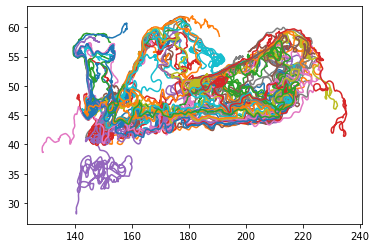

In [5]:
# Make a simple plot
x=dss['lonParticle']
y=dss['latParticle']
z=dss['zLevelParticle']
plt.plot(x,y)
plt.show()

/global/homes/t/takaito/miniconda3/envs/calc/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/homes/t/takaito/miniconda3/envs/calc/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/global/homes/t/takaito/miniconda3/envs/calc/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(

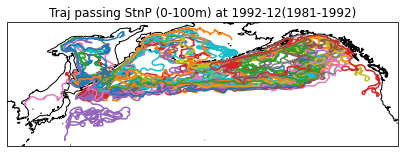

In [6]:
# make it nicer
fig=plt.figure(figsize=(7, 4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
ax.coastlines()
# ax.gridlines(linestyle='--')
cf=ax.plot(x,y, transform=ccrs.PlateCarree())
#fig.colorbar(cf, ax=ax,shrink=0.7, label='Temperature ($^\circ$C)')
ax.set_title('Traj passing '+loclab+' ('+str(depc-ddep)+'-'+str(depc+ddep)+'m) at '+year+'-'+mon+'(1981-1992)')
#! mkdir fig
fn='Fig_traj_'+loclab+'_'+year+'-'+mon
#plt.savefig(outdir+'/'+fn+'.pdf',bbox_inches="tight",dpi=300)
#plt.savefig(outdir+'/'+fn+'.png',bbox_inches="tight",dpi=300)
plt.show()